In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import os
import librosa
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

2023-02-01 12:58:31.218011: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
audio_file_path ="UrbanSound8K/14114-4-0-0.wav"

librosa_audio_data, librosa_sample_rate = librosa.load(audio_file_path)

In [3]:
print(librosa_audio_data)

[-0.00036316  0.003339    0.00058542 ...  0.00740885 -0.01643462
 -0.02770476]


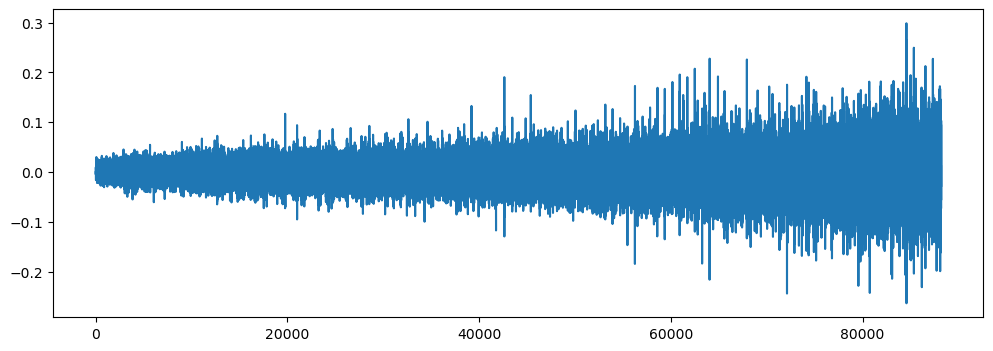

In [4]:
plt.figure(figsize= (12,4))
plt.plot(librosa_audio_data)
plt.show()

In [5]:
mfccs = librosa.feature.mfcc(y=librosa_audio_data, sr=librosa_sample_rate, n_mfcc=40)
print(mfccs.shape)

(40, 173)


In [6]:
mfccs

array([[-3.11305786e+02, -2.73016907e+02, -2.59112061e+02, ...,
        -1.20988495e+02, -1.19933105e+02, -1.29393616e+02],
       [ 1.36475124e+01,  9.62326145e+00,  2.37941780e+01, ...,
         1.38982296e+01,  1.21670704e+01,  1.65751190e+01],
       [-2.78623390e+01, -2.88105164e+01, -2.72658482e+01, ...,
        -4.88322525e+01, -4.87660599e+01, -4.44250488e+01],
       ...,
       [ 7.45889568e+00,  8.62604809e+00,  4.62362480e+00, ...,
         4.33059120e+00,  5.83112001e+00,  1.11560163e+01],
       [-1.07560177e+01, -9.51702404e+00, -8.36163616e+00, ...,
        -3.96332026e+00, -3.11141109e+00,  3.37380934e+00],
       [-4.15072250e+00,  2.17539132e-01,  2.07896209e+00, ...,
         5.71629143e+00,  6.82855892e+00,  7.08488178e+00]], dtype=float32)

In [7]:
audio_dataset_path = "UrbanSound8K/audio/"
metadata = pd.read_csv("UrbanSound8K/metadata/UrbanSound8K.csv")
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [8]:
def features_extractor(file):
    audio, sample_rate = librosa.load(file_name, res_type="kaiser_fast")
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    
    return mfccs_scaled_features

In [9]:
extracted_features= []

for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path), "fold"+str(row["fold"])+"/", str(row["slice_file_name"]))
    final_class_labels = row["class"]
    data = features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

3555it [04:31, 12.86it/s]/Users/furkangulenc/opt/anaconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1323
  return f(*args, **kwargs)
8326it [10:36, 23.22it/s]/Users/furkangulenc/opt/anaconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1103
  return f(*args, **kwargs)
/Users/furkangulenc/opt/anaconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1523
  return f(*args, **kwargs)
8732it [11:02, 13.17it/s]


In [10]:
extracted_features_df = pd.DataFrame(extracted_features, columns=["feature","class"])
extracted_features_df.head()

,feature,class
0,"[-217.35526, 70.22338, -130.38527, -53.282898,...",dog_bark
1,"[-424.09818, 109.34077, -52.919525, 60.86475, ...",children_playing
2,"[-458.79114, 121.38419, -46.52066, 52.00812, -...",children_playing
3,"[-413.89984, 101.66373, -35.42945, 53.036358, ...",children_playing
4,"[-446.60352, 113.68541, -52.402206, 60.302044,...",children_playing


In [11]:
len(extracted_features_df)

8732

In [12]:
x = np.array(extracted_features_df["feature"].tolist())
y = np.array(extracted_features_df["class"].tolist()) 

In [13]:
x.shape

(8732, 40)

In [15]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [16]:
y.shape

(8732, 10)

In [14]:
labelencoder = LabelEncoder()
y = to_categorical(labelencoder.fit_transform(y))

In [17]:
y[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [18]:
x_train, x_test,y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=0)

In [19]:
x_train

array([[-1.31104706e+02,  1.12505905e+02, -2.25746956e+01, ...,
         3.24665260e+00, -1.36902380e+00,  2.75575471e+00],
       [-1.36703424e+01,  9.10850830e+01, -7.79273319e+00, ...,
        -3.25305080e+00, -5.27745295e+00, -1.55697155e+00],
       [-4.98715439e+01,  2.65352815e-01, -2.05009365e+01, ...,
         2.85459447e+00, -1.60920465e+00,  3.52480578e+00],
       ...,
       [-4.27012360e+02,  9.26230469e+01,  3.12939739e+00, ...,
         7.42641270e-01,  7.33490825e-01,  7.11009145e-01],
       [-1.45754608e+02,  1.36265778e+02, -3.35155220e+01, ...,
         1.46811950e+00, -2.00917006e+00, -8.82181704e-01],
       [-4.21031342e+02,  2.10654541e+02,  3.49066067e+00, ...,
        -5.38886738e+00, -3.37136054e+00, -1.56651139e+00]], dtype=float32)

In [20]:
y_train

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [21]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [22]:
x

array([[-2.1735526e+02,  7.0223381e+01, -1.3038527e+02, ...,
        -1.6930530e+00, -6.1698395e-01,  3.8600540e-01],
       [-4.2409818e+02,  1.0934077e+02, -5.2919525e+01, ...,
         5.3489316e-01, -5.4468727e-01,  4.4632071e-01],
       [-4.5879114e+02,  1.2138419e+02, -4.6520660e+01, ...,
         2.0768483e+00,  1.6962967e+00, -9.6140945e-01],
       ...,
       [-3.0388824e+02,  1.1135945e+02, -4.5941563e+01, ...,
        -3.0292380e+00,  2.7170293e+00,  7.6197419e+00],
       [-3.4411008e+02,  1.2545021e+02, -5.4903439e+01, ...,
        -7.9082441e+00, -1.6414586e+00,  5.6668439e+00],
       [-3.1560281e+02,  9.4854805e+01, -3.7222340e+01, ...,
         6.1386454e-01, -1.1449189e+01, -6.0105858e+00]], dtype=float32)

In [24]:
x_train.shape

(6985, 40)

In [25]:
x_test.shape

(1747, 40)

In [26]:
y_train.shape

(6985, 10)

In [27]:
y_test.shape

(1747, 10)

In [28]:
num_labels = 10

In [31]:
model = Sequential()

model.add(Dense(125, input_shape=(40,)))
model.add(Activation("relu"))
model.add(Dropout(0.5))

model.add(Dense(250))
model.add(Activation("relu"))
model.add(Dropout(0.5))

model.add(Dense(125))
model.add(Activation("relu"))
model.add(Dropout(0.5))

model.add(Dense(num_labels))
model.add(Activation("softmax"))

In [32]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 125)               5125      
                                                                 
 activation_6 (Activation)   (None, 125)               0         
                                                                 
 dropout_6 (Dropout)         (None, 125)               0         
                                                                 
 dense_9 (Dense)             (None, 250)               31500     
                                                                 
 activation_7 (Activation)   (None, 250)               0         
                                                                 
 dropout_7 (Dropout)         (None, 250)               0         
                                                                 
 dense_10 (Dense)            (None, 125)              

In [33]:
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

In [36]:
epochscount = 600
num_batch_size = 32

model.fit(x_train, y_train, batch_size = num_batch_size, epochs = epochscount, validation_data=(x_test, y_test), verbose=1)

Epoch 1/600
219/219 [==============================] - 1s 3ms/step - loss: 0.7472 - accuracy: 0.7545 - val_loss: 0.5667 - val_accuracy: 0.8260
Epoch 2/600
219/219 [==============================] - 1s 2ms/step - loss: 0.7013 - accuracy: 0.7684 - val_loss: 0.5551 - val_accuracy: 0.8243
Epoch 3/600
219/219 [==============================] - 1s 3ms/step - loss: 0.7085 - accuracy: 0.7639 - val_loss: 0.5688 - val_accuracy: 0.8271
Epoch 4/600
219/219 [==============================] - 1s 3ms/step - loss: 0.7189 - accuracy: 0.7595 - val_loss: 0.5594 - val_accuracy: 0.8351
Epoch 5/600
219/219 [==============================] - 1s 3ms/step - loss: 0.6977 - accuracy: 0.7661 - val_loss: 0.5857 - val_accuracy: 0.8197
Epoch 6/600
219/219 [==============================] - 1s 3ms/step - loss: 0.7229 - accuracy: 0.7661 - val_loss: 0.5666 - val_accuracy: 0.8243
Epoch 7/600
219/219 [==============================] - 1s 2ms/step - loss: 0.7076 - accuracy: 0.7698 - val_loss: 0.5606 - val_accuracy: 0.8311

Epoch 58/600
219/219 [==============================] - 1s 3ms/step - loss: 0.6871 - accuracy: 0.7735 - val_loss: 0.5393 - val_accuracy: 0.8397
Epoch 59/600
219/219 [==============================] - 1s 3ms/step - loss: 0.7153 - accuracy: 0.7658 - val_loss: 0.5754 - val_accuracy: 0.8311
Epoch 60/600
219/219 [==============================] - 1s 5ms/step - loss: 0.7164 - accuracy: 0.7648 - val_loss: 0.5745 - val_accuracy: 0.8260
Epoch 61/600
219/219 [==============================] - 1s 4ms/step - loss: 0.7077 - accuracy: 0.7707 - val_loss: 0.5460 - val_accuracy: 0.8311
Epoch 62/600
219/219 [==============================] - 1s 4ms/step - loss: 0.6947 - accuracy: 0.7675 - val_loss: 0.5509 - val_accuracy: 0.8346
Epoch 63/600
219/219 [==============================] - 1s 3ms/step - loss: 0.7116 - accuracy: 0.7676 - val_loss: 0.5775 - val_accuracy: 0.8317
Epoch 64/600
219/219 [==============================] - 1s 3ms/step - loss: 0.6922 - accuracy: 0.7664 - val_loss: 0.5546 - val_accuracy:

Epoch 115/600
219/219 [==============================] - 1s 3ms/step - loss: 0.6776 - accuracy: 0.7754 - val_loss: 0.5723 - val_accuracy: 0.8340
Epoch 116/600
219/219 [==============================] - 1s 3ms/step - loss: 0.6807 - accuracy: 0.7729 - val_loss: 0.5773 - val_accuracy: 0.8185
Epoch 117/600
219/219 [==============================] - 1s 3ms/step - loss: 0.6911 - accuracy: 0.7772 - val_loss: 0.5436 - val_accuracy: 0.8414
Epoch 118/600
219/219 [==============================] - 1s 4ms/step - loss: 0.6846 - accuracy: 0.7747 - val_loss: 0.5699 - val_accuracy: 0.8288
Epoch 119/600
219/219 [==============================] - 1s 3ms/step - loss: 0.6811 - accuracy: 0.7765 - val_loss: 0.5445 - val_accuracy: 0.8288
Epoch 120/600
219/219 [==============================] - 1s 3ms/step - loss: 0.6613 - accuracy: 0.7804 - val_loss: 0.5745 - val_accuracy: 0.8237
Epoch 121/600
219/219 [==============================] - 1s 3ms/step - loss: 0.7036 - accuracy: 0.7661 - val_loss: 0.5784 - val_ac

219/219 [==============================] - 1s 2ms/step - loss: 0.6993 - accuracy: 0.7772 - val_loss: 0.5496 - val_accuracy: 0.8329
Epoch 172/600
219/219 [==============================] - 0s 2ms/step - loss: 0.6900 - accuracy: 0.7749 - val_loss: 0.5550 - val_accuracy: 0.8346
Epoch 173/600
219/219 [==============================] - 0s 2ms/step - loss: 0.6814 - accuracy: 0.7781 - val_loss: 0.5306 - val_accuracy: 0.8369
Epoch 174/600
219/219 [==============================] - 0s 2ms/step - loss: 0.6649 - accuracy: 0.7870 - val_loss: 0.5118 - val_accuracy: 0.8563
Epoch 175/600
219/219 [==============================] - 1s 3ms/step - loss: 0.6828 - accuracy: 0.7802 - val_loss: 0.5476 - val_accuracy: 0.8369
Epoch 176/600
219/219 [==============================] - 1s 2ms/step - loss: 0.6797 - accuracy: 0.7778 - val_loss: 0.5140 - val_accuracy: 0.8483
Epoch 177/600
219/219 [==============================] - 1s 2ms/step - loss: 0.6755 - accuracy: 0.7808 - val_loss: 0.5299 - val_accuracy: 0.8483

219/219 [==============================] - 0s 2ms/step - loss: 0.6870 - accuracy: 0.7772 - val_loss: 0.5286 - val_accuracy: 0.8426
Epoch 228/600
219/219 [==============================] - 1s 2ms/step - loss: 0.6494 - accuracy: 0.7830 - val_loss: 0.5240 - val_accuracy: 0.8363
Epoch 229/600
219/219 [==============================] - 0s 2ms/step - loss: 0.6756 - accuracy: 0.7832 - val_loss: 0.5780 - val_accuracy: 0.8226
Epoch 230/600
219/219 [==============================] - 0s 2ms/step - loss: 0.6814 - accuracy: 0.7739 - val_loss: 0.5404 - val_accuracy: 0.8237
Epoch 231/600
219/219 [==============================] - 1s 2ms/step - loss: 0.6772 - accuracy: 0.7784 - val_loss: 0.5306 - val_accuracy: 0.8351
Epoch 232/600
219/219 [==============================] - 0s 2ms/step - loss: 0.6708 - accuracy: 0.7785 - val_loss: 0.5435 - val_accuracy: 0.8231
Epoch 233/600
219/219 [==============================] - 0s 2ms/step - loss: 0.6747 - accuracy: 0.7807 - val_loss: 0.5393 - val_accuracy: 0.8317

219/219 [==============================] - 1s 2ms/step - loss: 0.6530 - accuracy: 0.7878 - val_loss: 0.5325 - val_accuracy: 0.8414
Epoch 284/600
219/219 [==============================] - 1s 3ms/step - loss: 0.6618 - accuracy: 0.7843 - val_loss: 0.5473 - val_accuracy: 0.8283
Epoch 285/600
219/219 [==============================] - 1s 4ms/step - loss: 0.6591 - accuracy: 0.7820 - val_loss: 0.5349 - val_accuracy: 0.8248
Epoch 286/600
219/219 [==============================] - 1s 2ms/step - loss: 0.7100 - accuracy: 0.7694 - val_loss: 0.5432 - val_accuracy: 0.8380
Epoch 287/600
219/219 [==============================] - 0s 2ms/step - loss: 0.6535 - accuracy: 0.7780 - val_loss: 0.5411 - val_accuracy: 0.8397
Epoch 288/600
219/219 [==============================] - 1s 3ms/step - loss: 0.6418 - accuracy: 0.7910 - val_loss: 0.5575 - val_accuracy: 0.8323
Epoch 289/600
219/219 [==============================] - 1s 4ms/step - loss: 0.6873 - accuracy: 0.7717 - val_loss: 0.5579 - val_accuracy: 0.8351

219/219 [==============================] - 0s 2ms/step - loss: 0.6708 - accuracy: 0.7804 - val_loss: 0.5370 - val_accuracy: 0.8334
Epoch 340/600
219/219 [==============================] - 0s 2ms/step - loss: 0.6601 - accuracy: 0.7853 - val_loss: 0.5238 - val_accuracy: 0.8432
Epoch 341/600
219/219 [==============================] - 0s 2ms/step - loss: 0.6655 - accuracy: 0.7822 - val_loss: 0.5315 - val_accuracy: 0.8300
Epoch 342/600
219/219 [==============================] - 0s 2ms/step - loss: 0.6676 - accuracy: 0.7885 - val_loss: 0.5332 - val_accuracy: 0.8369
Epoch 343/600
219/219 [==============================] - 1s 2ms/step - loss: 0.6474 - accuracy: 0.7870 - val_loss: 0.5330 - val_accuracy: 0.8420
Epoch 344/600
219/219 [==============================] - 1s 2ms/step - loss: 0.6889 - accuracy: 0.7729 - val_loss: 0.5055 - val_accuracy: 0.8454
Epoch 345/600
219/219 [==============================] - 0s 2ms/step - loss: 0.6705 - accuracy: 0.7774 - val_loss: 0.5240 - val_accuracy: 0.8351

219/219 [==============================] - 0s 2ms/step - loss: 0.6584 - accuracy: 0.7854 - val_loss: 0.5150 - val_accuracy: 0.8477
Epoch 396/600
219/219 [==============================] - 0s 2ms/step - loss: 0.6656 - accuracy: 0.7797 - val_loss: 0.5180 - val_accuracy: 0.8329
Epoch 397/600
219/219 [==============================] - 0s 2ms/step - loss: 0.6411 - accuracy: 0.7944 - val_loss: 0.5374 - val_accuracy: 0.8420
Epoch 398/600
219/219 [==============================] - 0s 2ms/step - loss: 0.6406 - accuracy: 0.7931 - val_loss: 0.5126 - val_accuracy: 0.8414
Epoch 399/600
219/219 [==============================] - 0s 2ms/step - loss: 0.6432 - accuracy: 0.7951 - val_loss: 0.5222 - val_accuracy: 0.8500
Epoch 400/600
219/219 [==============================] - 0s 2ms/step - loss: 0.6446 - accuracy: 0.7870 - val_loss: 0.5375 - val_accuracy: 0.8380
Epoch 401/600
219/219 [==============================] - 1s 2ms/step - loss: 0.6375 - accuracy: 0.7931 - val_loss: 0.5273 - val_accuracy: 0.8460

219/219 [==============================] - 1s 2ms/step - loss: 0.6544 - accuracy: 0.7883 - val_loss: 0.5214 - val_accuracy: 0.8346
Epoch 452/600
219/219 [==============================] - 1s 3ms/step - loss: 0.6267 - accuracy: 0.7928 - val_loss: 0.5347 - val_accuracy: 0.8369
Epoch 453/600
219/219 [==============================] - 0s 2ms/step - loss: 0.6446 - accuracy: 0.7841 - val_loss: 0.5253 - val_accuracy: 0.8437
Epoch 454/600
219/219 [==============================] - 0s 2ms/step - loss: 0.6578 - accuracy: 0.7825 - val_loss: 0.5334 - val_accuracy: 0.8363
Epoch 455/600
219/219 [==============================] - 0s 2ms/step - loss: 0.6278 - accuracy: 0.7937 - val_loss: 0.5068 - val_accuracy: 0.8437
Epoch 456/600
219/219 [==============================] - 0s 2ms/step - loss: 0.6279 - accuracy: 0.7943 - val_loss: 0.5221 - val_accuracy: 0.8420
Epoch 457/600
219/219 [==============================] - 0s 2ms/step - loss: 0.6306 - accuracy: 0.7930 - val_loss: 0.5218 - val_accuracy: 0.8466

219/219 [==============================] - 0s 2ms/step - loss: 0.6420 - accuracy: 0.7958 - val_loss: 0.5185 - val_accuracy: 0.8489
Epoch 508/600
219/219 [==============================] - 0s 2ms/step - loss: 0.6364 - accuracy: 0.7927 - val_loss: 0.5064 - val_accuracy: 0.8477
Epoch 509/600
219/219 [==============================] - 0s 2ms/step - loss: 0.6172 - accuracy: 0.7980 - val_loss: 0.5196 - val_accuracy: 0.8397
Epoch 510/600
219/219 [==============================] - 0s 2ms/step - loss: 0.6328 - accuracy: 0.7890 - val_loss: 0.5142 - val_accuracy: 0.8414
Epoch 511/600
219/219 [==============================] - 1s 2ms/step - loss: 0.6554 - accuracy: 0.7871 - val_loss: 0.5202 - val_accuracy: 0.8472
Epoch 512/600
219/219 [==============================] - 0s 2ms/step - loss: 0.6454 - accuracy: 0.7917 - val_loss: 0.5352 - val_accuracy: 0.8397
Epoch 513/600
219/219 [==============================] - 0s 2ms/step - loss: 0.6555 - accuracy: 0.7878 - val_loss: 0.5151 - val_accuracy: 0.8414

219/219 [==============================] - 0s 2ms/step - loss: 0.6325 - accuracy: 0.7963 - val_loss: 0.5187 - val_accuracy: 0.8472
Epoch 564/600
219/219 [==============================] - 0s 2ms/step - loss: 0.6362 - accuracy: 0.7914 - val_loss: 0.5448 - val_accuracy: 0.8432
Epoch 565/600
219/219 [==============================] - 0s 2ms/step - loss: 0.6441 - accuracy: 0.7940 - val_loss: 0.5288 - val_accuracy: 0.8369
Epoch 566/600
219/219 [==============================] - 0s 2ms/step - loss: 0.6531 - accuracy: 0.7936 - val_loss: 0.5308 - val_accuracy: 0.8454
Epoch 567/600
219/219 [==============================] - 0s 2ms/step - loss: 0.6386 - accuracy: 0.7917 - val_loss: 0.5095 - val_accuracy: 0.8580
Epoch 568/600
219/219 [==============================] - 0s 2ms/step - loss: 0.6434 - accuracy: 0.7911 - val_loss: 0.5226 - val_accuracy: 0.8449
Epoch 569/600
219/219 [==============================] - 0s 2ms/step - loss: 0.6388 - accuracy: 0.7933 - val_loss: 0.5274 - val_accuracy: 0.8414

In [37]:
validation_test_set_accuracy = model.evaluate(x_test,y_test, verbose=0)
print(validation_test_set_accuracy[1])

0.8408700823783875


In [38]:
x_test[1]

array([-466.17957   ,    1.0950246 ,  -34.01389   ,   35.33935   ,
        -14.88148   ,  -19.12843   ,   -0.581684  ,  -16.130577  ,
        -21.339075  ,    7.673635  ,  -29.16449   ,  -18.950253  ,
         -2.9579992 ,   -8.162331  ,  -15.153101  ,   -6.6048055 ,
         -7.5685973 ,    9.340646  ,   14.4331    ,   21.934181  ,
         20.861397  ,    1.3340123 ,  -19.228804  ,   -4.630231  ,
         -1.0564744 ,    3.215267  ,   -6.984281  ,  -16.414577  ,
        -10.0286455 ,   13.009954  ,    0.53346074,  -23.843391  ,
        -15.267321  ,    9.245734  ,   10.367627  ,   -0.58320105,
         -1.2624055 ,   17.700016  ,   13.847462  ,   -5.1862826 ],
      dtype=float32)

In [43]:
np.argmax(model.predict(x_test), axis=-1)

55/55 [==============================] - 0s 1ms/step


array([5, 3, 4, ..., 1, 9, 9])

In [44]:
filename = "UrbanSound8K/28284-3-0-0.wav"
sound_signal, sample_rate = librosa.load(filename, res_type="kaiser_fast")
mfccs_features = librosa.feature.mfcc(y=sound_signal, sr= sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T, axis=0) 

In [45]:
print(mfccs_scaled_features)

[-243.18086      68.17888     -67.270874      1.1580989   -17.85366
    5.7712436    -8.383862     22.271801     -6.6793594    15.137313
   -8.572166      8.424313    -13.209879      8.759533     -2.4790158
   14.748741     -6.0824094     6.457428    -10.532296      4.7085977
   -6.9659452     4.82705      -2.4791596     5.227268     -2.9504845
    2.218203     -5.011836      0.42725554   -5.387379      1.2466857
   -1.6493        1.838381     -4.1202717    -1.031642     -3.56252
   -1.4555998    -2.273821     -0.7092459    -1.1553285    -0.6064067 ]


In [46]:
mfccs_scaled_features = mfccs_scaled_features.reshape(1,-1)

In [47]:
mfccs_scaled_features.shape

(1, 40)

In [48]:
result_array = model.predict(mfccs_scaled_features)

1/1 [==============================] - 0s 23ms/step


In [49]:
result_array

array([[1.7505168e-03, 4.1264612e-03, 3.7712399e-02, 8.0854589e-01,
        2.1346793e-02, 2.5289454e-03, 6.8332337e-02, 3.8463524e-05,
        1.6511803e-02, 3.9106384e-02]], dtype=float32)

In [53]:
result_classes=["air_conditioner","car_horn", "children", "dog_bark", "drilling", "engine_idling", "gun_shot","jack_hammer","siren","street_music"]


result = np.argmax(result_array[0])
print(result_classes[result])

dog_bark
